##  Piza Nava Vladimir - 111-494


## Laboratorio 3

## Link al repositorio: https://github.com/vladi-13/Laboratorios/blob/main/Laboratorio3.ipynb

## Link al dataset: https://www.kaggle.com/datasets/vladi13/dataset-flores-piza-nava-vladimir

Este código configura el entorno para entrenar una red neuronal en **PyTorch** utilizando **DirectML**, una alternativa a CUDA para GPUs AMD.  

###  Configuración del Dispositivo  
Se obtiene el dispositivo disponible con **DirectML** y se fija una semilla aleatoria (`torch.manual_seed(42)`) para asegurar que los experimentos sean reproducibles.  

###  Mensaje de Confirmación  
Se imprime el dispositivo en uso para verificar que DirectML está funcionando correctamente.  

In [1]:
import torch
import torch_directml
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

# Configurar el dispositivo DirectML
device = torch_directml.device()
torch.manual_seed(42)  # Para reproducibilidad

print(f"Usando dispositivo: {device}")

Usando dispositivo: privateuseone:0


## Explicación del Código  

Este código carga un dataset de imágenes desde un CSV, lo divide en **80% entrenamiento y 20% validación**, y lo prepara para PyTorch.  

### 1️ Carga y División del Dataset  
- Se carga el CSV con rutas de imágenes y etiquetas.  
- Se mapean las etiquetas de clase a números.  
- Se usa `train_test_split` para dividir los datos manteniendo la proporción de clases (`stratify`).  

### 2️ Transformaciones  
- Se redimensionan las imágenes a **64x64 píxeles**.  
- Se convierten a tensores y se normalizan con media y desviación estándar de **0.5**.  

### 3️ Definición del Dataset  
- `FlowerDataset` lee las rutas, abre las imágenes y aplica transformaciones.  
- Devuelve un **tensor de imagen y su etiqueta numérica**.  

### 4️ Creación de DataLoaders  
- `train_loader`: carga datos de entrenamiento en lotes aleatorios.  
- `val_loader`: carga datos de validación sin mezcla.  

Finalmente, se imprime el tamaño de cada conjunto.  

In [ ]:
from sklearn.model_selection import train_test_split

# Cargar CSV
csv_path = "dataset_flores.csv"  # Ajusta la ruta según corresponda
data = pd.read_csv(csv_path)

# Crear un mapeo de clases a números
class_mapping = {name: idx for idx, name in enumerate(sorted(data.iloc[:, 1].unique()))}
print("Mapa de clases:", class_mapping)  # Verificar el mapeo

# Dividir el dataset en 80% entrenamiento y 20% validación
train_data, val_data = train_test_split(data, test_size=0.2, stratify=data.iloc[:, 1], random_state=42)

# Definir transformaciones
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Reducir resolución
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Definir clase del dataset personalizado
class FlowerDataset(Dataset):
    def __init__(self, csv_data, transform=None):
        self.data = csv_data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_path = self.data.iloc[index, 0]  # Primera columna: rutas de imágenes
        label = self.data.iloc[index, 1]     # Segunda columna: etiquetas de clases
        label = class_mapping[label]         # Convertir la etiqueta a entero

        # Abrir imagen
        image = Image.open(img_path).convert("RGB")

        # Aplicar transformaciones
        if self.transform:
            image = self.transform(image)

        return image, label

# Crear datasets de entrenamiento y validación
train_dataset = FlowerDataset(train_data, transform=transform)
val_dataset = FlowerDataset(val_data, transform=transform)

# Crear dataloaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=0)

print(f"Dataset dividido: {len(train_dataset)} entrenamiento, {len(val_dataset)} validación")

Mapa de clases: {'Astromelia': 0, 'Cartucho': 1, 'Chapulin': 2, 'Lirio': 3, 'Obispo': 4}
Dataset dividido: 40000 entrenamiento, 10000 validación


# Red Neuronal Convolucional (CNN) en PyTorch

Este código define una **CNN** para la clasificación de imágenes en **5 clases**. La arquitectura incluye:

1. **Capas convolucionales**: Extraen características de la imagen usando convoluciones, normalización (`BatchNorm2d`), activación (`ReLU`) y reducción de dimensiones (`MaxPool2d`).
2. **Capas completamente conectadas**: Procesan las características extraídas para realizar la clasificación final. Incluyen activación (`ReLU`), regularización (`Dropout`) y una capa de salida con 5 neuronas.
3. **Método `forward()`**: Define el flujo de los datos a través de la red, desde las capas convolucionales hasta la clasificación final.

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes=5):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            # Primer bloque convolucional
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Segundo bloque convolucional
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Tercer bloque convolucional
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Reduce a (128, 8, 8)
        )

        # Capas totalmente conectadas
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 8 * 8, 256),  # Tamaño corregido
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    # Definir el flujo hacia adelante
    def forward(self, x):
        x = self.conv_layers(x) # Pasar por las capas convolucionales
        x = x.view(x.size(0), -1)  # Aplanar para la capa totalmente conectada
        x = self.fc_layers(x) # Pasar por las capas totalmente conectadas
        return x

# Configuración del Entrenamiento en PyTorch

Este código define los elementos esenciales para entrenar una **CNN** en PyTorch:

1. **Modelo**: Se instancia la red neuronal `CNN` y se mueve al dispositivo (`device`).
2. **Función de pérdida**: Se usa `CrossEntropyLoss`, adecuada para clasificación multiclase.
3. **Optimizador**: Se emplea `AdamW`, un optimizador eficiente con `weight_decay` para regularización.
4. **Parámetros de entrenamiento**:
   - `epochs = 10`: Número de épocas para entrenar.
   - `patience = 2`: Número de épocas sin mejora antes de detener el entrenamiento temprano.

In [10]:
import torch.optim as optim

# Definir modelo antes de usarlo
model = CNN(num_classes=5).to(device)

# Definir función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

# Número de épocas y paciencia
epochs = 10
patience = 2

# Entrenamiento de un Modelo en PyTorch

Este código entrena una red neuronal en PyTorch, validando su rendimiento en cada época y aplicando detención temprana si no mejora.

## Estructura del Código

1. **Inicialización**  
   - Se define la mejor pérdida de validación (`best_val_loss`).  
   - Se usa un contador (`counter`) para llevar el seguimiento de épocas sin mejora.

2. **Entrenamiento**  
   - Se activa el modo de entrenamiento (`model.train()`).  
   - Se recorren los datos en `train_loader`.  
   - Se realiza la propagación hacia adelante, cálculo de pérdida, retropropagación y actualización de pesos.  
   - Se calcula la pérdida promedio de la época.  

3. **Validación**  
   - Se activa el modo de evaluación (`model.eval()`).  
   - Se desactivan los gradientes (`torch.no_grad()`).  
   - Se calcula la pérdida en los datos de validación (`val_loader`).  

4. **Guardado del Mejor Modelo**  
   - Si la pérdida de validación mejora, el modelo se guarda.  
   - Si no mejora, se incrementa el contador de paciencia.  

5. **Detención Temprana**  
   - Si no hay mejora tras varias épocas, se detiene el entrenamiento.  

In [12]:
from tqdm import tqdm

best_val_loss = float("inf")
counter = 0  # Contador de épocas sin mejora

for epoch in range(epochs):
    model.train() # Modo de entrenamiento
    running_loss = 0.0

    for images, labels in tqdm(train_loader, desc=f"Época {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device, dtype=torch.long)

        optimizer.zero_grad() # Inicializar gradientes
        outputs = model(images) # Propagación hacia adelante    
        loss = criterion(outputs, labels) # Calcular pérdida
        loss.backward() # Propagación hacia atrás               
        optimizer.step() # Actualizar pesos

        running_loss += loss.item() # Acumular pérdida

    # Calcular pérdida de entrenamiento
    train_loss = running_loss / len(train_loader)
    print(f"Época {epoch+1} - Pérdida de entrenamiento: {train_loss:.4f}")

    # Evaluación en validación (si tienes val_loader)
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:  # Usa val_loader si tienes
            images, labels = images.to(device), labels.to(device, dtype=torch.long)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    print(f"Época {epoch+1} - Pérdida de validación: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("✅ Modelo mejorado y guardado.")
    else:
        counter += 1
        print(f"🔸 No hay mejora. Paciencia: {counter}/{patience}")

    if counter >= patience:
        print("⏹️ Early Stopping activado. Deteniendo entrenamiento.")
        break

Época 1/10: 100%|██████████| 157/157 [03:26<00:00,  1.32s/it]


Época 1 - Pérdida de entrenamiento: 0.0359
Época 1 - Pérdida de validación: 0.0231
✅ Modelo mejorado y guardado.


Época 2/10: 100%|██████████| 157/157 [03:27<00:00,  1.32s/it]


Época 2 - Pérdida de entrenamiento: 0.0326
Época 2 - Pérdida de validación: 0.0457
🔸 No hay mejora. Paciencia: 1/2


Época 3/10: 100%|██████████| 157/157 [03:36<00:00,  1.38s/it]


Época 3 - Pérdida de entrenamiento: 0.0316
Época 3 - Pérdida de validación: 0.0175
✅ Modelo mejorado y guardado.


Época 4/10: 100%|██████████| 157/157 [03:21<00:00,  1.29s/it]


Época 4 - Pérdida de entrenamiento: 0.0260
Época 4 - Pérdida de validación: 0.0535
🔸 No hay mejora. Paciencia: 1/2


Época 5/10: 100%|██████████| 157/157 [03:12<00:00,  1.23s/it]


Época 5 - Pérdida de entrenamiento: 0.0189
Época 5 - Pérdida de validación: 0.0199
🔸 No hay mejora. Paciencia: 2/2
⏹️ Early Stopping activado. Deteniendo entrenamiento.


# Evaluación de un Modelo de Clasificación en PyTorch

##  Carga del Modelo Guardado
- Se define la arquitectura de la red neuronal.
- Se cargan los pesos entrenados desde `"best_model.pth"`.
- Se establece el **modo evaluación** (`model.eval()`) para desactivar el cálculo de gradientes.

##  Evaluación del Modelo
- Se recorre el conjunto de prueba (`val_loader`).
- Se desactiva el cálculo de gradientes con `torch.no_grad()`.
- Se generan predicciones y se compara con las etiquetas reales.
- Se calcula la precisión y la pérdida promedio.

##  Resultados
- Se imprime la **precisión (%)** y la **pérdida promedio** del modelo.

In [65]:
# Cargar el modelo guardado
model = CNN(num_classes=5).to(device)  # Asegúrate de definir la arquitectura
model.load_state_dict(torch.load("best_model.pth", map_location=device))  # Cargar pesos
model.eval()  # Modo evaluación

def evaluar_modelo(model, val_loader, criterion, device):
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device, dtype=torch.long)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    avg_loss = total_loss / len(val_loader)

    print(f'Precisión: {accuracy:.2f}% - Pérdida Promedio: {avg_loss:.4f}')
    return accuracy, avg_loss

# Evaluar el modelo cargado
accuracy, loss = evaluar_modelo(model, train_loader, criterion, device)

C:\Users\vladi\AppData\Local\Temp\ipykernel_21604\879310703.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth", map_locati

Precisión: 99.69% - Pérdida Promedio: 0.0100


# Explicación General del Código

## 1. Definición de Clases
Se define una lista con los nombres de las clases que el modelo puede predecir.

## 2. Selección de Imagen Aleatoria
Se lee un archivo CSV que contiene rutas de imágenes y sus etiquetas. Luego, se selecciona una imagen aleatoriamente.

## 3. Predicción de la Imagen
Se carga la imagen seleccionada, se transforma y se pasa por el modelo para obtener una predicción.

## 4. Carga del Modelo
Se carga un modelo previamente entrenado desde un archivo guardado (`best_model.pth`).

## 5. Visualización del Resultado
Se muestra la imagen con la clase real y la clase predicha por el modelo.

C:\Users\vladi\AppData\Local\Temp\ipykernel_21604\3017215872.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth", map_loca

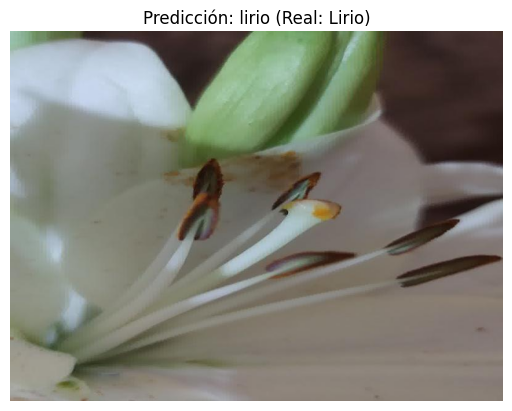

In [81]:
# Lista de clases
class_names = ["astromelia", "cartucho", "chapulin", "lirio", "obispo"]

def elegir_imagen_aleatoria(csv_path="dataset_flores.csv"):
    """Selecciona aleatoriamente una imagen desde un CSV con rutas y clases."""
    df = pd.read_csv(csv_path)
    
    if df.empty:
        return None, None
    
    fila = df.sample(n=1).iloc[0]  # Seleccionar una fila aleatoria
    return fila["image_path"], fila["label"]

def predecir_imagen(model, image_path, class_names, device):
    """Carga una imagen, la pasa por el modelo y devuelve la predicción."""
    image = Image.open(image_path).convert("RGB")  # Cargar la imagen
    image_tensor = transform(image).unsqueeze(0).to(device)  # Aplicar transformaciones

    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)  # Obtener la clase con mayor probabilidad

    prediccion = class_names[predicted.item()]  # Convertir índice a nombre de clase
    return image, prediccion

# Cargar modelo guardado
model = CNN(num_classes=5).to(device)
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()

# Predecir una imagen aleatoria desde el CSV
image_path, clase_real = elegir_imagen_aleatoria()
if image_path:
    image, prediccion = predecir_imagen(model, image_path, class_names, device)

    # Mostrar la imagen con su predicción y clase real
    plt.imshow(image)
    plt.title(f'Predicción: {prediccion} (Real: {clase_real})')
    plt.axis('off')
    plt.show()
else:
    print("No se encontraron imágenes en el CSV.")